In [ ]:
## Importing the necessary packages and initialising various parameters ##
import torch
import os
from torch.utils.data import Dataset
import cv2
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from skimage.io import imread, imsave
from skimage.transform import resize
import torchvision
import torchvision.transforms.functional as G


# define the number of channels in the input, number of classes and number of levels in the U-Net model
Num_channels = 1
Num_levels= 5

# Initializing learning rate, number of epochs to train and the batch size
Init_lr= 0.001
Num_epochs = 20
Batch_size = 4

# Define threshold to filter weak predictions
Threshold= 0.5

#Input image dimensions
Input_image_width = 650
Input_image_height = 650


#Define the test split
Test_split= 0.10

#Determine the device to be used for training and evaluation
Device= "cuda" if torch.cuda.is_available() else "cpu"
#Determine if we will be pinning memory during data loading
Pin_memory = True if Device == "cuda" else False


In [ ]:
## Dataset loading ##


# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((Input_image_height,
		Input_image_width)),
	transforms.ToTensor()])


class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		imagePath = self.imagePaths[idx]  # grab the image path from the current index
		image = cv2.imread(imagePath)
		mask = cv2.imread(self.maskPaths[idx],0)
	 # check to see if we are applying any transformations
		if self.transforms is not None:
			image = self.transforms(image) # apply the transformations to both image and its mask
			mask = self.transforms(mask)
		# return a tuple of the image and its mask
		return (image, mask)


# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images('/content/drive/MyDrive/Brain_Hemorrage_Dataset/Segmentation/Image')))
maskPaths = sorted(list(paths.list_images('/content/drive/MyDrive/Brain_Hemorrage_Dataset/Segmentation/Mask')))
# partition the data into training and testing splits using 90% of the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths,
	test_size=Test_split, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]


# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
	transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,
    transforms=transforms)

print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=Batch_size, pin_memory=Pin_memory,
	num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=Batch_size, pin_memory=Pin_memory,
	num_workers=os.cpu_count())

[INFO] found 263 examples in the training set...
[INFO] found 30 examples in the test set...


In [ ]:
## Segmentation Model ##


class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))
	

class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs


class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,concatenate them with the current upsampled features,and pass the concatenated output through the current decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

		
class UNet(Module):
  def __init__(self, encChannels=(3, 16, 32, 64),decChannels=(64, 32, 16),nbClasses=1, retainDim=True,outSize=(650,650)):
    super().__init__()
	#initialize the encoder and decoder
    self.encoder = Encoder(encChannels)
    self.decoder = Decoder(decChannels)
	# initialize the regression head and store the class variables
    self.head = Conv2d(decChannels[-1], nbClasses, 1)
    self.retainDim = retainDim
    self.outSize = outSize
  def forward(self, x):
    # grab the features from the encoder
    encFeatures = self.encoder(x)
		# pass the encoder features through decoder making sure that their dimensions are suited for concatenation
    decFeatures = self.decoder(encFeatures[::-1][0],
			encFeatures[::-1][1:])
		# pass the decoder features through the regression head to obtain the segmentation mask
    map = self.head(decFeatures)
		# check to see if we are retaining the original output dimensions and if so, then resize the output to match them
    if self.retainDim:
      map = F.interpolate(map, self.outSize)
		# return the segmentation map
    return map


class DiceLoss(Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceScore, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1-dice


class IoULoss(Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [ ]:
## Training the Model ##


# initialize our UNet model
unet = UNet().to(Device)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
DiceFunc=DiceLoss()
opt = Adam(unet.parameters(), lr=Init_lr)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // Batch_size
testSteps = len(testDS) // Batch_size
# initialize a dictionary to store training history
H = {"Train_Loss": [], "Test_Loss": [] , "Dice_Score": [] }

# loop over epochs
print("Training the network...")
startTime = time.time()
for e in tqdm(range(Num_epochs)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	Dice_Loss=0
	IoU_Loss=0
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(Device), y.to(Device))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		Dice_Loss=DiceFunc(pred,y)
		IoU_Loss=IoULoss(pred,y)
		# first, zero out any previously accumulated gradients, then perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss	
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(Device), y.to(Device))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training history
	H["Train_Loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["Dice_Score"].append(Dice_Score.cpu().detach().numpy())
	# print the model training and validation information
	print("Epoch: {}/{}".format(e + 1, Num_epochs))
	print('Train loss:', avgTrainLoss.item())
	print('Dice Loss:',Dice_Loss.item())
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

Training the network...


  5%|▌         | 1/20 [00:13<04:08, 13.07s/it]

Epoch: 1/20
Train loss: 0.1465035378932953
Dice Score: 0.03559142351150513


 10%|█         | 2/20 [00:25<03:51, 12.84s/it]

Epoch: 2/20
Train loss: 0.03414051979780197
Dice Score: 0.06409920752048492


 15%|█▌        | 3/20 [00:38<03:36, 12.73s/it]

Epoch: 3/20
Train loss: 0.02960851415991783
Dice Score: 0.06767172366380692


 20%|██        | 4/20 [00:50<03:22, 12.66s/it]

Epoch: 4/20
Train loss: 0.031215069815516472
Dice Score: 0.026311613619327545


 25%|██▌       | 5/20 [01:03<03:08, 12.59s/it]

Epoch: 5/20
Train loss: 0.028593452647328377
Dice Score: 0.06790417432785034


 30%|███       | 6/20 [01:16<02:57, 12.69s/it]

Epoch: 6/20
Train loss: 0.02564297430217266
Dice Score: 0.057362690567970276


 35%|███▌      | 7/20 [01:29<02:46, 12.77s/it]

Epoch: 7/20
Train loss: 0.02561548538506031
Dice Score: 0.1779676377773285


 40%|████      | 8/20 [01:42<02:34, 12.84s/it]

Epoch: 8/20
Train loss: 0.023350967094302177
Dice Score: 0.13480010628700256


 45%|████▌     | 9/20 [01:55<02:21, 12.89s/it]

Epoch: 9/20
Train loss: 0.02150789462029934
Dice Score: 0.3483726680278778


 50%|█████     | 10/20 [02:08<02:09, 12.94s/it]

Epoch: 10/20
Train loss: 0.020136313512921333
Dice Score: 0.26705461740493774


 55%|█████▌    | 11/20 [02:21<01:56, 12.96s/it]

Epoch: 11/20
Train loss: 0.019626066088676453
Dice Score: 0.18039175868034363


 60%|██████    | 12/20 [02:33<01:43, 12.89s/it]

Epoch: 12/20
Train loss: 0.019859785214066505
Dice Score: 0.48955243825912476


 65%|██████▌   | 13/20 [02:46<01:30, 12.87s/it]

Epoch: 13/20
Train loss: 0.01789514720439911
Dice Score: 0.5073927044868469


 70%|███████   | 14/20 [02:59<01:16, 12.79s/it]

Epoch: 14/20
Train loss: 0.018499255180358887
Dice Score: 0.18554063141345978


 75%|███████▌  | 15/20 [03:11<01:03, 12.72s/it]

Epoch: 15/20
Train loss: 0.018626650795340538
Dice Score: 0.7228138446807861


 80%|████████  | 16/20 [03:24<00:50, 12.67s/it]

Epoch: 16/20
Train loss: 0.01855706237256527
Dice Score: 0.14859071373939514


 85%|████████▌ | 17/20 [03:36<00:37, 12.61s/it]

Epoch: 17/20
Train loss: 0.017775943502783775
Dice Score: 0.08571433275938034


 90%|█████████ | 18/20 [03:49<00:25, 12.57s/it]

Epoch: 18/20
Train loss: 0.01736421138048172
Dice Score: 0.4191873371601105


 95%|█████████▌| 19/20 [04:01<00:12, 12.55s/it]

Epoch: 19/20
Train loss: 0.017528319731354713
Dice Score: 0.08339857310056686


100%|██████████| 20/20 [04:14<00:00, 12.73s/it]

Epoch: 20/20
Train loss: 0.016980087384581566
Dice Score: 0.6001366376876831
[INFO] total time taken to train the model: 254.51s


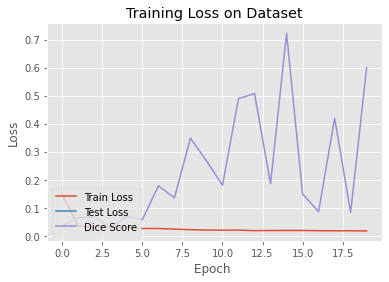

In [ ]:
## Plotting the training loss ##
plt.style.use("ggplot")
plt.figure()
plt.plot(H["Train_Loss"], label="Train Loss")
plt.plot(H["Test_Loss"], label="Test Loss")
plt.plot(H["Dice_Score"], label="Dice Score")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch ")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [ ]:
import tensorflow as tf
#define augmentations 
inference_transform = A.Compose([
    A.Resize(650, 650),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),ToTensorV2()])

#define function for predictions
def predict(model, img, device):
    model.eval()
    with torch.no_grad():
        images = img.to(device)
        output = model(images)
        predicted_masks = (output.squeeze() >= 0.5).float().cpu().numpy()
        
    return(predicted_masks)

#define function to load image and output mask
def get_mask(img_path):
  image = cv2.imread(img_path)
  original_height, original_width = tuple(image.shape[:2])
    
  image_trans = inference_transform(image = image)
  image_trans = image_trans["image"]
  image_trans = image_trans.unsqueeze(0)
  image_mask = predict(unet, image_trans, Device)
  return(image_mask)

Image


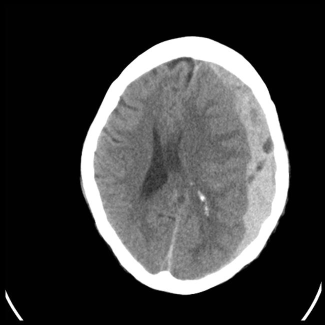

Ground Truth


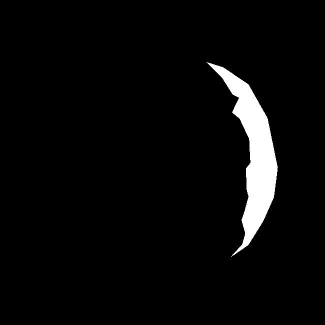

Predicted Mask


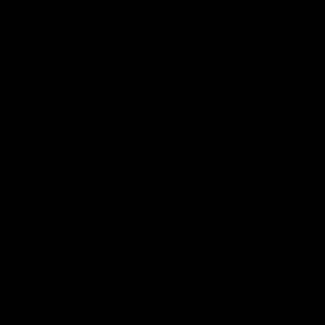

In [ ]:
#image example
from google.colab.patches import cv2_imshow
Image_path = '/content/drive/MyDrive/Brain_Hemorrage_Dataset/Segmentation/Image/103.jpg'
Image = cv2.imread(Image_path)
Image = cv2.resize(Image,(325,325))   

Ground_truth_path= '/content/drive/MyDrive/Brain_Hemorrage_Dataset/Segmentation/Mask/103.jpg'
Ground_truth= cv2.imread(Ground_truth_path)
Ground_truth = cv2.resize(Ground_truth,(325,325))   

predicted_mask = get_mask(Image_path)
predicted_mask = cv2.resize(predicted_mask,(325,325))   

print('Image')
cv2_imshow(Image)
print('Ground Truth')
cv2_imshow(Ground_truth)
print('Predicted Mask')
cv2_imshow(predicted_mask)